In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import requests
from collections import defaultdict
import numpy as np
import xml.etree.ElementTree as ET
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor
import os

In [2]:
file_path = "Журнал.xlsx"
data = pd.read_excel(file_path)
data['Дата'] = pd.to_datetime(data['Дата'], format='%d.%m.%Y')
data.sort_values(by='Дата', inplace=True) # Сортируем данные по дате для корректной обработки


start_date = datetime.strptime("2021-01-29", "%Y-%m-%d")
end_date = datetime.strptime("2025-05-02", "%Y-%m-%d")

total_coms = 0
# Инициализация массивов и начальных значений
portfolio = []
current_portfolio = {}
cash_balance = 0
unique_tickers = {}

dates_irr = []
values_irr = []
# Создаем список всех дат в диапазоне
date_range = pd.date_range(start=start_date, end=end_date)

def is_oblig(ticker):
    if ticker.startswith('SU') or ticker.startswith('RU') and ticker != 'RU000A0HGNG6': return True
    else: return False
    
for current_date in date_range:
    # Добавляем состояние портфеля на начало дня
    portfolio.append({
        'Дата': current_date,
        'Активы': current_portfolio.copy(),
        'Деньги на счете': cash_balance
    })

    # Фильтруем операции для текущей даты
    daily_operations = data[data['Дата'] == current_date]

    # Обрабатываем операции в текущую дату
    for _, row in daily_operations.iterrows():
        operation_type = row['Операция']
        ticker = row['Тикер']
        volume = row['Объем транзакции в штуках']
        transaction_amount = row['Объем транзакции в целевой валюте']

        if operation_type in ["Ввод денежных средств", "Купонный доход", "Доход по предоставлениям займа", "Брокерская комиссия", "Дивиденды", "Пеня (Списание)"]:
            cash_balance += transaction_amount
            if operation_type in ["Брокерская комиссия", "Доход по предоставлениям займа", "Пеня (Списание)"]:
                total_coms += transaction_amount
        if operation_type in ["Ввод денежных средств","Вычет"]:
            dates_irr.append(current_date.to_pydatetime())
            values_irr.append(-transaction_amount)
        elif operation_type in ["Покупка актива", "Продажа актива","Доход от погашения ценных бумаг"]:
            if ticker not in current_portfolio:
                current_portfolio[ticker] = 0
                if ticker not in unique_tickers:
                    unique_tickers[ticker] = {'Дата появления': current_date, 'Дата ухода': None}

            if operation_type == "Покупка актива":
                current_portfolio[ticker] += volume
                cash_balance -= transaction_amount
               
            elif (operation_type == "Продажа актива") or (operation_type == "Доход от погашения ценных бумаг"):
                current_portfolio[ticker] -= volume
                cash_balance += transaction_amount
              
                # Удаляем тикер, если количество становится 0
                if current_portfolio[ticker] == 0:
                    unique_tickers[ticker]['Дата ухода'] = current_date
                    del current_portfolio[ticker]    
    # Добавляем состояние портфеля на конец дня
    portfolio.append({
        'Дата': current_date,
        'Активы': current_portfolio.copy(),
        'Деньги на счете': cash_balance
    })
print('OK')

OK


In [3]:
start_date1 = datetime.strptime("2024-02-11", "%Y-%m-%d")
def fetch_rate_for_date(date: datetime):
    """
    Загружает курс доллара для одной даты.
    """
    date_str = date.strftime('%d/%m/%Y')
    url = f"http://www.cbr.ru/scripts/XML_daily.asp?date_req={date_str}"
    response = requests.get(url)
    response.encoding = 'windows-1251'
    if response.status_code != 200:
        return date_str, None  # Если ошибка, возвращаем дату и None
    
    tree = ET.fromstring(response.text)
    for currency in tree.findall('Valute'):
        if currency.find('CharCode').text == 'USD':
            value = currency.find('Value').text
            return date_str, float(value.replace(',', '.'))

    return date_str, None  # Если USD не найден

def get_rates_for_date_range(start_date: datetime, end_date: datetime):
    """
    Загружает курсы доллара для диапазона дат.
    """
    delta = end_date - start_date
    all_dates = [start_date + timedelta(days=i) for i in range(delta.days + 1)]
    
    # Используем ThreadPoolExecutor для ускорения
    with ThreadPoolExecutor(max_workers=5) as executor:
        results = executor.map(fetch_rate_for_date, all_dates)
    
    # Собираем данные в словарь
    return dict(results)

usd_rates = get_rates_for_date_range(start_date1, end_date)

def read_usd_rates(filename):
    df = pd.read_csv(filename, sep=';', encoding='utf-8')
    return dict(zip(df['Date'], df['USD_Rate']))

# Читаем файл и преобразуем в словарь
usd_rates_loaded = read_usd_rates("usd_rates.csv")

usd_rates = {**usd_rates, **usd_rates_loaded}
print("OK")

OK


In [4]:
usd_rates['02/05/2025']

81.4933

In [5]:
# Формируем массив уникальных тикеров
tickers_array = []
for ticker, dates in unique_tickers.items():
    if (ticker != 'Дата'):
        tickers_array.append({
            'Тикер': ticker,
            'Дата появления': dates['Дата появления'],
            'Дата ухода': dates['Дата ухода']
        })
# Функция для загрузки данных с API Московской биржи
def fetch_moex_data(ticker, start_date, end_date):
    def get_data(url, params):
        response = requests.get(url, params=params)
        response.raise_for_status()
        j = response.json()
        data = [
            {k: r[i] for i, k in enumerate(j['candles']['columns'])}
            for r in j['candles']['data']
        ]
        return pd.DataFrame(data)
    
    if ticker == "EQMX":
        url1 = f"http://iss.moex.com/iss/engines/stock/markets/shares/securities/VTBX/candles.json"
        dayX = datetime.strptime("2022-07-21", "%Y-%m-%d")
        params_1 = {
            'from': start_date,
            'till': dayX,
            'interval': 24
        }
        url2 = f"http://iss.moex.com/iss/engines/stock/markets/shares/securities/EQMX/candles.json"
        middle_date = dayX + (end_date - dayX) / 2
        params_2 = {
            'from': dayX,
            'till': middle_date,
            'interval': 24
        }
        params_3 = {
            'from': middle_date,
            'till': end_date,
            'interval': 24
        }
        data_part_1 = get_data(url1, params_1)
        data_part_2 = get_data(url2, params_2)
        data_part_3 = get_data(url2, params_3)
        return pd.concat([data_part_1, data_part_2, data_part_3], ignore_index=True)
        
    if ticker.startswith('SU') :
        url = f"http://iss.moex.com/iss/engines/stock/markets/bonds/boards/TQOB/securities/{ticker}/candles.json"
    elif ticker.startswith('RU'):
        url = f"http://iss.moex.com/iss/engines/stock/markets/bonds/boards/TQCB/securities/{ticker}/candles.json"
    else:
        url = f"http://iss.moex.com/iss/engines/stock/markets/shares/securities/{ticker}/candles.json"
    if ticker == 'RU000A0HGNG6':
        url = f"https://iss.moex.com/iss/engines/stock/markets/shares/securities/{ticker}/candles.json"
        
    middle_date = start_date + (end_date - start_date) / 2
    params_1 = {
        'from': start_date,
        'till': middle_date,
        'interval': 24
    }
    params_2 = {
        'from': middle_date,
        'till': end_date,
        'interval': 24
    }
    data_part_1 = get_data(url, params_1)
    data_part_2 = get_data(url, params_2)
    
    return pd.concat([data_part_1, data_part_2], ignore_index=True)

# Загрузка данных для каждого тикера
ticker_data = {}
data_finex = pd.read_excel("historical-dynamic.xls")
for ticker_info in tickers_array:
    ticker = ticker_info['Тикер']
    start = ticker_info['Дата появления']
    end = ticker_info['Дата ухода'] if ticker_info['Дата ухода'] else end_date
    print(ticker, start, end)
    if (ticker == "FXDM") or (ticker == "FXCN") or (ticker == "FXUS") or (ticker == "FXEM"):
        prices = data_finex[ticker + " in USD"]
        tmp = 0
        if (ticker == "FXEM"): tmp = 1
        if (ticker == "FXDM"): tmp = 8
        if (ticker == "FXUS"): tmp = 17
        if (ticker == "FXCN"): tmp = 20
        dates = data_finex["Дата."+str(tmp)]
        dates = pd.to_datetime(dates, format="%d.%m.%Y").dt.strftime("%Y-%m-%d %H:%M:%S")
        ticker_data[ticker] = pd.DataFrame({"begin": dates, "close": prices, "open": prices})
    else:
        ticker_data[ticker] = fetch_moex_data(ticker, start, end)

SU26236RMFS8 2022-02-15 00:00:00 2024-12-24 00:00:00
EQMX 2022-02-15 00:00:00 2025-05-02 00:00:00
RU000A100D63 2022-02-15 00:00:00 2022-08-04 00:00:00
SU26220RMFS2 2022-02-15 00:00:00 2022-12-07 00:00:00
SBGB 2022-02-15 00:00:00 2024-09-20 00:00:00
SU26215RMFS2 2022-02-15 00:00:00 2023-08-16 00:00:00
SU26211RMFS1 2022-02-15 00:00:00 2023-01-25 00:00:00
SU26227RMFS7 2022-02-15 00:00:00 2024-07-17 00:00:00
SU26228RMFS5 2022-02-15 00:00:00 2024-12-24 00:00:00
SU26229RMFS3 2022-02-15 00:00:00 2024-12-24 00:00:00
FXUS 2022-02-15 00:00:00 2025-05-02 00:00:00
FXDM 2022-02-15 00:00:00 2025-05-02 00:00:00
FXCN 2022-02-15 00:00:00 2025-05-02 00:00:00
FXEM 2022-02-15 00:00:00 2024-08-12 00:00:00
SU26237RMFS6 2022-02-15 00:00:00 2024-12-24 00:00:00
TMOS 2022-11-25 00:00:00 2025-05-02 00:00:00
SU26238RMFS4 2023-12-12 00:00:00 2025-05-02 00:00:00
BOND 2023-12-12 00:00:00 2025-05-02 00:00:00
SBGD 2023-12-29 00:00:00 2025-05-02 00:00:00
TLCB 2024-01-05 00:00:00 2025-05-02 00:00:00
LQDT 2024-09-20 00:0

In [12]:
def calculate_portfolio_value(portfolio, start_date, end_date):
    all_data = []
    ticker_last_price = []
    tmp_start = []
    tmp_end = []
    for i in range(len(tickers_array)):
        all_data.append([])
        ticker_last_price.append(0)
        tmp_start.append(0)
        tmp_end.append(0)
    for i in range (len(portfolio)):
        for g in range(len(tickers_array)):
            date, ticker_start, ticker_end, ticker = portfolio[i]['Дата'], tickers_array[g]['Дата появления'], tickers_array[g]['Дата ухода'], tickers_array[g]['Тикер']
            obl_coef, price_bool = 1, 0
            if is_oblig(ticker): obl_coef = 10
            if g == 10 or g == 11 or g ==12 or g == 13: obl_coef = usd_rates[date.strftime('%d/%m/%Y')]
            day_price = 'open'
            if date == portfolio[i-1]['Дата']:  day_price = 'close'
            if date <= ticker_start:
                if (date==ticker_start and tmp_start[g]==0): tmp_start[g]=1
                elif (date==ticker_start and tmp_start[g] == 1): price_bool = 1     
            elif ticker_end == None: price_bool = 1
            elif date >= ticker_end:
                if (date== ticker_end and tmp_end[g]==0):
                    tmp_end[g]=1
                    price_bool=1
            else: price_bool=1
            
            if price_bool:
                if not ((ticker_data[ticker]).loc[ticker_data[ticker]['begin'] ==  (date).strftime('%Y-%m-%d %H:%M:%S'), day_price]).empty:
                    ticker_last_price[g] = obl_coef * ((ticker_data[ticker]).loc[ticker_data[ticker]['begin'] ==  (date).strftime('%Y-%m-%d %H:%M:%S'), day_price]).iloc[0]
                all_data[g].append(portfolio[i]['Активы'][ticker] * ticker_last_price[g])   
            else:
                all_data[g].append(0)
    return all_data

result = calculate_portfolio_value(portfolio, start_date, end_date)
dates = [portfolio[i]['Дата'].to_pydatetime() for i in range(len(portfolio))]
x = []
for i in range(len(portfolio)):
    tmp = 0
    for g in range(len(tickers_array)):
        tmp += result[g][i]
    tmp += portfolio[i]['Деньги на счете']
    x.append(tmp)

print("OK")

OK


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton

# Данные
cashflow_dates = dates_irr  # даты денежных потоков
cashflows = values_irr  # значения денежных потоков
datess = dates # даты стоимости портфеля
portfolio_values = x  # стоимость портфеля на каждую дату

# Преобразование в форматы pandas
def parse_dates(datess):
    return pd.to_datetime(datess)

cashflow_dates = parse_dates(cashflow_dates)
datess = parse_dates(datess)

# Функция расчета XIRR
def xirr(cashflows, cashflow_dates):
    def xnpv(rate):
        return sum(cf / (1 + rate)**((date - cashflow_dates[0]).days / 365) for cf, date in zip(cashflows, cashflow_dates))

    try:
        return newton(lambda r: xnpv(r), 0.1)
    except (RuntimeError, OverflowError):
        return np.nan

# Расчет доходности для каждой даты в массиве dates
returns = []
for current_date in datess:
    # Используем только денежные потоки до текущей даты
    relevant_cashflows = [cf for cf, date in zip(cashflows, cashflow_dates) if date < current_date]
    relevant_dates = [date for date in cashflow_dates if date <= current_date]

    if relevant_cashflows and relevant_dates:
        # Добавляем стоимость портфеля как последний денежный поток
        current_index = (datess == current_date).argmax()
        relevant_cashflows.append(portfolio_values[current_index])
        relevant_dates.append(current_date)

        # Вычисляем доходность
        irr = xirr(relevant_cashflows, relevant_dates)
        returns.append(100*irr)
    else:
        returns.append(np.nan)
print("OK")

<ipython-input-13-bd2a0a85eeae>:22: RuntimeWarning: invalid value encountered in scalar power
  return sum(cf / (1 + rate)**((date - cashflow_dates[0]).days / 365) for cf, date in zip(cashflows, cashflow_dates))


OK


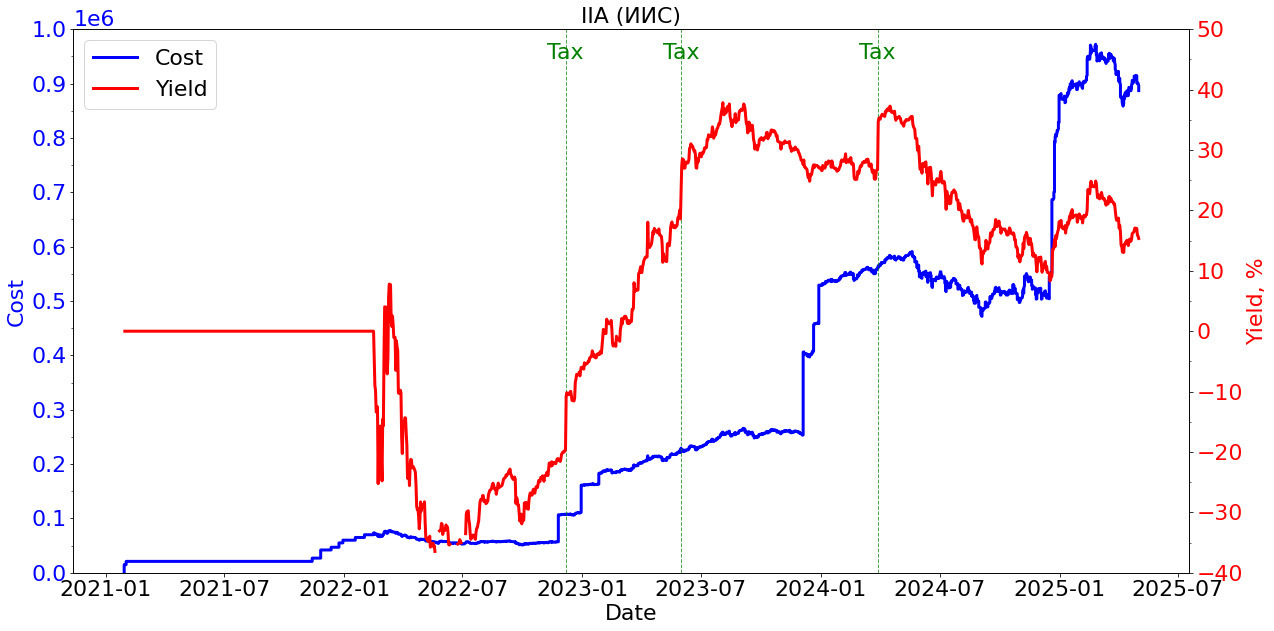

In [36]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) #деления на графиках
font_size = 22  # <-- Задаём здесь размер шрифта
plt.rcParams.update({
    'font.size': font_size,        # базовый размер шрифта
    'axes.titlesize': font_size,   # размер заголовков осей
    'axes.labelsize': font_size,   # размер подписей осей
    'xtick.labelsize': font_size,  # размер подписей делений по x
    'ytick.labelsize': font_size,  # размер подписей делений по y
    'legend.fontsize': font_size,  # размер шрифта легенды
    'figure.titlesize': font_size  # размер заголовка графика
})

# Создаем фигуру и первую ось
fig, ax1 = plt.subplots(figsize=(20, 10))

# Первая ось (слева)
l1, = ax1.plot(dates, x, color='blue', label='Cost', linewidth=3)
ax1.set_xlabel('Date', fontsize=font_size)
ax1.set_ylabel('Cost',fontsize=font_size, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 1000000)
ax1.yaxis.set_major_locator(MultipleLocator(100000))
ax1.yaxis.set_minor_locator(MultipleLocator(50000))

# Вторая ось (справа)
ax2 = ax1.twinx()
l2, = ax2.plot(dates, returns, color='red', label='Yield', linewidth=3)
ax2.set_ylabel('Yield, %', color='red', fontsize=font_size)
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(-40, 50)
ax2.yaxis.set_major_locator(MultipleLocator(10))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
#ax1.grid(which='major', color='gray', linestyle='--',  linewidth=0.5)
#ax1.grid(which='minor', color='gray', linestyle='--',  linewidth=0.2)

# Объединяем легенды и размещаем их в одном месте
lines = [l1, l2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

vertical_lines = [datetime(2022, 12, 6), datetime(2023, 6, 1), datetime(2024, 3, 28)]
for x_line in vertical_lines:
    ax1.axvline(x=x_line, color='green', linestyle='--', linewidth=1, alpha=0.7)
    ax1.text(x_line, ax1.get_ylim()[1] - 55000, f'Tax', color='green', ha='center')
    
# Отображаем график
plt.title("IIA (ИИС)",fontsize=font_size)
plt.show()
my_path = os.path.abspath('pics')
DPI = 300
fig.savefig(os.path.join(my_path, "doxa"+'.png'), dpi = DPI, bbox_inches = 'tight')    


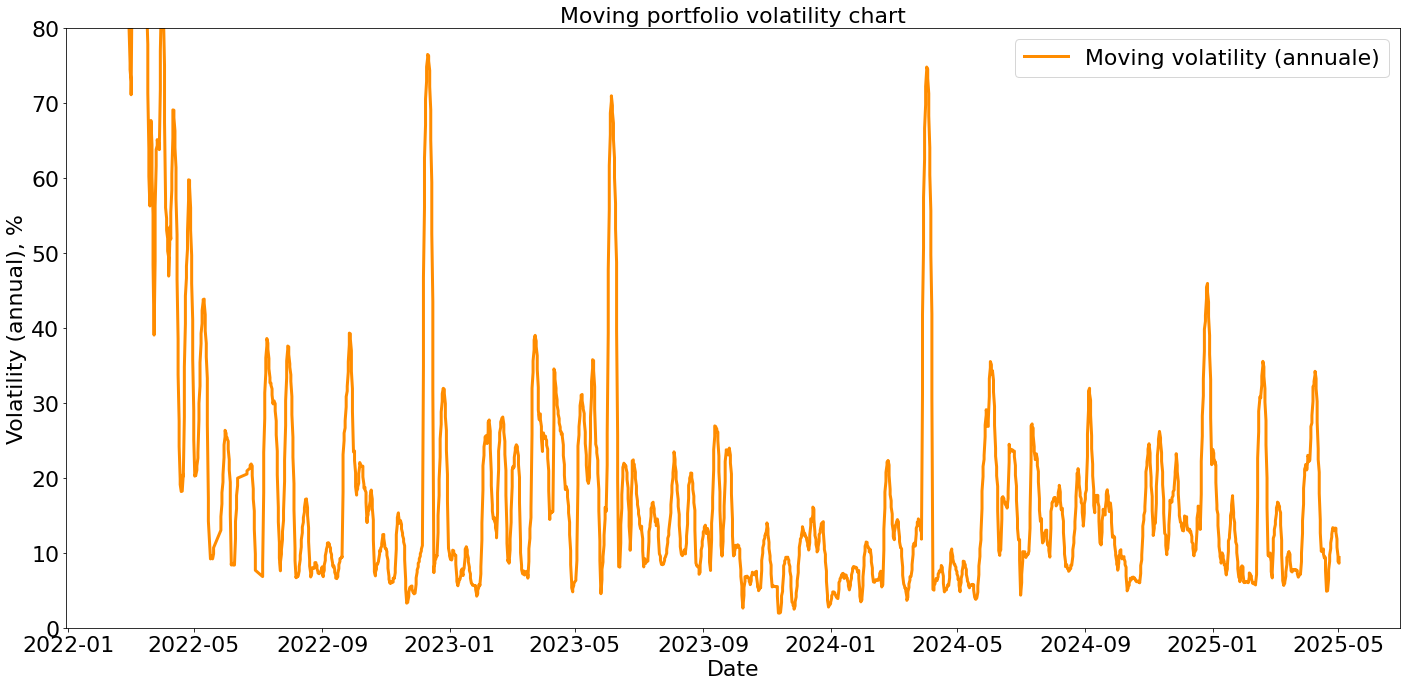

In [33]:

# Создаем DataFrame из массива доходностей
df_returns = pd.DataFrame({'Дата': dates, 'Доходность, %': returns})
df_returns.set_index('Дата', inplace=True)

# Преобразуем проценты в доли для расчета волатильности
df_returns['Доходность'] = df_returns['Доходность, %']

# Очистим от NaN и слишком малых значений (например, ниже 1e-10)
df_returns_cleaned = df_returns.copy()
df_returns_cleaned = df_returns_cleaned[np.abs(df_returns_cleaned['Доходность']) > 1e-10]
df_returns_cleaned = df_returns_cleaned.dropna()

# Скользящая волатильность (на окне 21 день, годовая)
df_returns_cleaned['Скользящая волатильность'] = (
    df_returns_cleaned['Доходность'].rolling(window=21).std() * np.sqrt(252)
)

# Построим график
plt.figure(figsize=(20, 10))
plt.tight_layout()
plt.plot(df_returns_cleaned.index, df_returns_cleaned['Скользящая волатильность'], label='Moving volatility (annuale)', color='darkorange', linewidth=3)
plt.title('Moving portfolio volatility chart')
plt.xlabel('Date')
plt.ylabel('Volatility (annual), %')
plt.ylim([0,80])

    
plt.legend()
plt.tight_layout()
plt.show()
